In [24]:
import argparse
from dataset import *
from models import * 
from generation import *
import numpy as np

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
DIR_PATH = "dataset/poems.csv"
SOV_TOKEN = "<SOV>" # start of verse
EOV_TOKEN = "<EOV>" # end of verse

parser = argparse.ArgumentParser()
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--sequence_length', type=int, default=10)
args, unknown = parser.parse_known_args()

# Define the dataset and dataloader
dataset = SpanishPoemsDataset(DIR_PATH, SOV_TOKEN, EOV_TOKEN, args)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

print(dataset.__getitem__(3))
print('Vocab:', len(dataset.unique_words))

(tensor([2449, 1375,    1,    0,    6,   15, 2450, 2451,    5,   66]), tensor([1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452]))
Vocab: 7506


In [26]:
# Set hyperparameters

input_size = len(dataset.unique_words) # size of the vocabulary for the input sequence
output_size = len(dataset.unique_words) # size of the vocabulary for the target sequence
hidden_size = 128
batch_size = args.batch_size
sequence_length = args.sequence_length
num_epochs = args.max_epochs
learning_rate = 0.001
save_epochs = 2

# Define the loss function 
criterion = nn.CrossEntropyLoss()



# GENERATION 

## MODEL 1: Baseline (1 layer)

In [27]:
num_layers = 1

In [28]:
# Instantiate the encoder and decoder, and optimizer
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
optimizer_1 = optim.Adam(list(LSTM_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [29]:
encoder_1_ckpt = "saved_models/encoder_2.pt"
decoder_1_ckpt = "saved_models/decoder_2.pt"

In [30]:
perplexity_1 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    LSTM_encoder, GRU_decoder, dataset, 
    0, 1, max_length=50, temperature=0.8, top_k=10, 
    encoder_type='LSTM', 
    encoder_ckpt=encoder_1_ckpt, 
    decoder_ckpt=decoder_1_ckpt
)
    perplexity_1.append(perplexity)


## MODEL 2: 2 layers 

In [31]:
num_layers = 2

In [32]:
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
optimizer_2 = optim.Adam(list(LSTM_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [33]:
encoder_2_ckpt = "saved_models/encoder_9.pt"
decoder_2_ckpt = "saved_models/decoder_9.pt"

In [34]:
perplexity_2 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    LSTM_encoder, GRU_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_type='LSTM', 
    encoder_ckpt=encoder_2_ckpt, 
    decoder_ckpt=decoder_2_ckpt
)
    perplexity_2.append(perplexity)

## MODEL 3: 3 layers

In [35]:
num_layers = 3

In [36]:
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
optimizer_3 = optim.Adam(list(LSTM_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [37]:
encoder_3_ckpt = "saved_models/encoder_10.pt"
decoder_3_ckpt = "saved_models/decoder_10.pt"

In [38]:
perplexity_3 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    LSTM_encoder, GRU_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_type='LSTM',
    encoder_ckpt=encoder_3_ckpt, 
    decoder_ckpt=decoder_3_ckpt
)
    perplexity_3.append(perplexity)

## MODEL 4: 4 layers

In [51]:
num_layers = 4

In [52]:
GRU_decoder = GRUDecoder(hidden_size, output_size, num_layers)
LSTM_encoder = LSTMEncoder(input_size, hidden_size, num_layers)
optimizer_4 = optim.Adam(list(LSTM_encoder.parameters()) + list(GRU_decoder.parameters()), lr=learning_rate)

In [53]:
encoder_4_ckpt = "saved_models/encoder_11.pt"
decoder_4_ckpt = "saved_models/decoder_11.pt"

In [54]:
perplexity_4 = []
for _ in range(50): 
    _, perplexity = generate_poem_GRU(
    LSTM_encoder, GRU_decoder, dataset, 
    0, 1, max_length=40, temperature=0.8, top_k=10, 
    encoder_type='LSTM',
    encoder_ckpt=encoder_4_ckpt, 
    decoder_ckpt=decoder_4_ckpt
)
    perplexity_4.append(perplexity)

# COMPARISON 

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [56]:
data = [
    perplexity_1, 
    perplexity_2,
    perplexity_3,
    perplexity_4
]

labels=[ 'Baseline', '2', '3', '4']

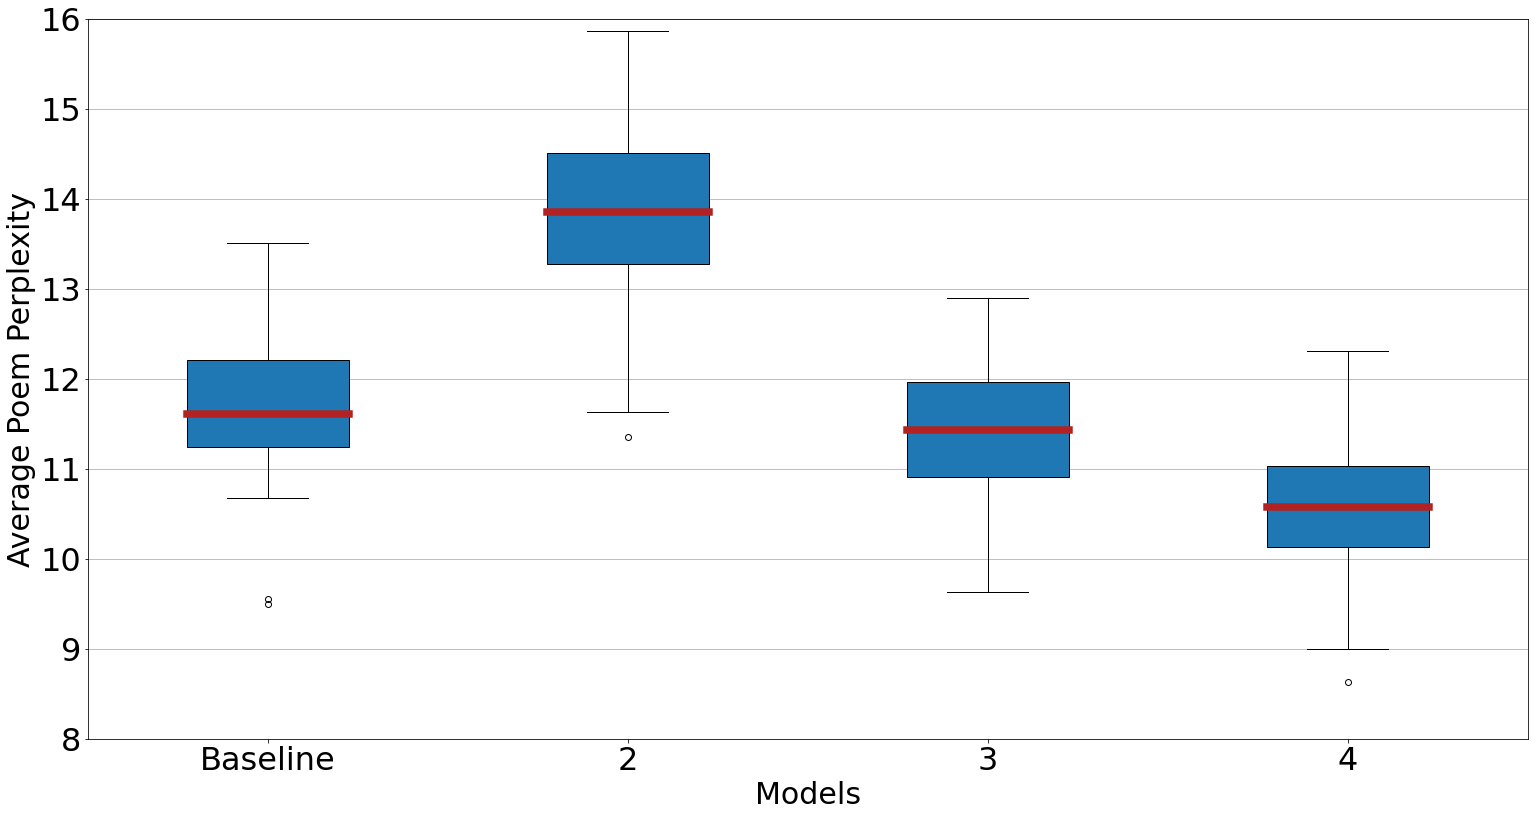

In [57]:
mpl.rcParams['font.size'] = 32
medianprops = dict(linestyle='-', linewidth=7.5, color='firebrick')
#threshold = 1
fig = plt.figure(figsize =(20, 10))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, patch_artist=True, medianprops=medianprops, labels=labels) 
#ax.axvline(threshold, c = "red", linestyle="--", alpha = 0.5)
ax.set_ylim(8,16)
plt.ylabel('Average Poem Perplexity', fontsize=30)
plt.xlabel('Models', fontsize=30)
plt.gca().yaxis.grid(True)
#plt.savefig("boxplot.jpg", bbox_inches='tight')
plt.show()

In [58]:
import pandas as pd 

d = {

    'Baseline': perplexity_1, 
    '2': perplexity_2, 
    '3': perplexity_3, 
    '4': perplexity_4
}

df = pd.DataFrame(data=d)
df.head()

,Baseline,2,3,4
0,11.419774,14.902080,10.491490,9.079750
1,13.383567,16.775092,12.573324,10.655496
2,12.396188,13.681355,12.487185,11.500523
3,13.159290,14.595754,10.712749,11.406278
4,11.435276,13.462140,12.461304,10.711031


In [59]:
model_names = df.columns #names of models

mean = df[model_names].mean()
pp_25per = df[model_names].quantile(q=.25)
pp_75per = df[model_names].quantile(q=.75)
maxPP = df[model_names].max()
minPP = df[model_names].min()
pp_5per = df[model_names].quantile(q=.05)
pp_95per = df[model_names].quantile(q=.95)

In [60]:
data_frames = [mean, pp_25per, pp_75per, maxPP, minPP, pp_5per, pp_95per]
column_names = ['meanPP', 'PP_25per', 'PP_75per', 'maxPP', 'minPP', 'PP_5per', 'PP_95per']
merged_df = pd.concat(data_frames, join='outer', axis=1)
merged_df.columns =column_names

In [61]:
merged_df

,meanPP,PP_25per,PP_75per,maxPP,minPP,PP_5per,PP_95per
Baseline,11.697833,11.240602,12.204828,13.507838,9.501723,10.770710,13.250133
2,13.849680,13.275333,14.504578,16.775092,11.349569,11.986802,15.208126
3,11.465516,10.903844,11.962833,12.896326,9.632325,10.159307,12.743299
4,10.510856,10.128824,11.032786,12.304364,8.630862,9.059124,11.734282


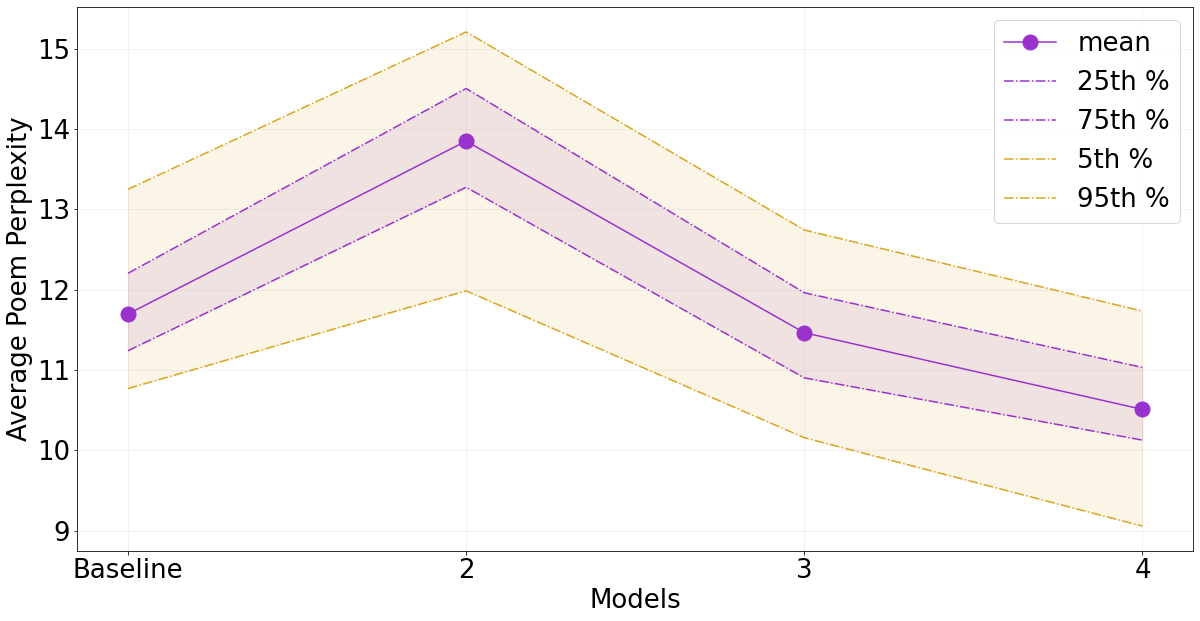

In [62]:
# source: https://towardsdatascience.com/the-matplotlib-line-plot-that-crushes-the-box-plot-912f8d2acd49


# Set the font size for all text on the plot
mpl.rcParams['font.size'] = 26

x = merged_df.index
y = merged_df.meanPP
y_low = merged_df.PP_25per
y_high = merged_df.PP_75per
y1_low = merged_df.PP_5per
y1_high = merged_df.PP_95per

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, y, color='darkorchid', marker='o', label='mean', markersize=15)
ax.plot(x, y_low, color='darkorchid', linestyle='-.', label='25th %')
ax.plot(x, y_high, color='darkorchid', linestyle='-.', label='75th %')
ax.plot(x, y1_low, color='goldenrod', linestyle='-.', label='5th %')
ax.plot(x, y1_high, color='goldenrod', linestyle='-.', label='95th %')
ax.legend()

ax.fill_between(x, y_low, y_high, alpha = .1, color = 'darkorchid')
ax.fill_between(x, y1_low, y1_high, alpha = .1, color = 'goldenrod')

ax.grid(alpha = .2, which='both') 
ax.set_ylabel('Average Poem Perplexity', fontsize=26)
ax.set_xlabel('Models', fontsize=26)

plt.savefig("exp3.jpg", bbox_inches='tight')
plt.show()
